In [3]:
import pandas as pd
import numpy as np
import os
import datetime
import time
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics 

#matplot lib notebooks display command
%matplotlib inline

#SET OPTIONS
pd.options.display.float_format = '{:,.2f}'.format
#GLOBAL VARIABLES
today = datetime.date.today()
#cwd = os.getcwd()

In [4]:
#load dataset
non_auto_df = pd.read_csv("../Data/non_automated_invoices_sample.csv", encoding='utf-8')
non_auto_df.dtypes

Unnamed: 0                 int64
ID                        object
COURTESYSENT__C             bool
COLLECTOR                 object
OUTSOURCE_PARTNER         object
RESELLER                  object
COLLECTION_STATUS         object
HAS_TAX_EXEMP               bool
HAS_REPLACEMENT_ORDER       bool
ESCALATION_STATUS         object
COLLECTOR_FORECAST        object
BILLING_COUNTRY           object
BILLING_LANGUAGE          object
PAYMENT_TERM              object
PAYMENT_TYPE              object
SFBILL__INVOICEAGE__C      int64
HAS_30DAY_EXTXN             bool
PAST_DUE_FLG                bool
LATE_PMT                    bool
DAYS_TO_PAY                int64
CURRENCY_CODE             object
TOTAL_TAX                float64
TOTAL_AMOUNT             float64
dtype: object

## Definition of features



'ID'- identification [DID NOT USE]

'COURTESYSENT__C' -         [DID NOT USE]

'COLLECTOR' - is this name of person collecting ?

'OUTSOURCE-PARTNER' - name of outsource partner ?

'RESELLER' - name of reseller?

'COLLECTION_STATUS' - status of collection (yes or no). Is this updated throughout process? [DID NOT USE]

'HAS-TAX-EXEMPT' - has tax exemption

'HAS-REPLACEMENT-ORDER' - has an order already for next billing cycle

'ESCALATION_STATUS' -I assume this is updated throughout process [DID NOT USE]

'COLLECTOR_FORECAST' -I assume this is updated throughout process [DID NOT USE]

'BILLING_COUNTRY' - country of origin for customer

'BILLING_LANGUAGE' -language of billing for customer

'PAYMENT_TERM' - is this a number of days? 

'PAYMENT_TYPE' - how customer is paying bill, you've already eliminated credit cards right?

'SFBILL___INVOICEAGE__C' INVOICE AGE [REMOVE]

'HAS_30DAY_EXTXN' - when is this information determined?  
'PAST_DUE_FLAG' - when is this updated? [DID NOT USE]

'LATE_PMT' - if customer made late payment [DID NOT USE]

'DAYS_TO_PAY' - days left before due?  [DID NOT USE]

'CURRENCY-CODE' - is this what kind of currency they are using?

'TOTAL-TAX' - total tax on product customer bought

'TOTAL AMOUNT' - total customer spent on product



In [5]:
#Normalize Numeric fields

def pre_process(df, dropcols=None):
    '''
    The pre_process function that will return a transformed dataframe
    Notes:
        1) dropcols should be a list
        2) integer varibles are transformed using mean normalization
    '''
    #drop columns input by the user
    if dropcols is not None:
        df = df.drop(columns=dropcols)
    
    #loop through remaining columns and apply the appropreate transform
    for i in df.columns:
        '''
        #mean normalization for int variables
        if df[i].dtype == "int64" or df[i].dtype == 'float64':
            mean = df[i].mean()
            if (df[i].max() - df[i].min()) == 0:
                denom = 1
                print("useless int column", i)
                break
            else:
                denom = (df[i].max() - df[i].min())
            df[i] = df[i].apply(lambda x: float(x - mean) / denom)
        '''
        #convert bool values to 1 and 0
        if df[i].dtype == "bool":
            df[i] = df[i].map({True: 1, False: 0})
        elif df[i].dtype == "object":
            df = pd.get_dummies(df, columns=[i], prefix = [i], dtype="int8") #, sparse=True
        
    return df



In [6]:
clean_df = pre_process(non_auto_df, dropcols=['ID','Unnamed: 0', 'COLLECTION_STATUS', \
                                              'ESCALATION_STATUS', 'COLLECTOR_FORECAST',
                                             'PAST_DUE_FLG', 'COURTESYSENT__C'])
clean_df.to_csv('../Data/clean_df.csv')
dtypes_df = clean_df.dtypes.to_frame('dtypes').reset_index()
dtypes_df.to_csv('../Data/clean_dtypes.csv')
print("done")

done


In [7]:
'''
Preprocessing DAYS_TO_PAY (first two already applied to global set?)
'''

print(clean_df.size)
#remove all entries >365
clean_df = clean_df.loc[lambda df: df['DAYS_TO_PAY'] <= 45]
#remove all negative entries 
clean_df = clean_df.loc[lambda df: df['DAYS_TO_PAY'] >= 0 ]
print(clean_df.size)
print("done")

51168040
32371553
done


In [8]:

X = clean_df.loc[:, clean_df.columns != "DAYS_TO_PAY"]
y = clean_df['DAYS_TO_PAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print(min(y))
print("done")

0
done


Model using 1e-05 as the regularization coefficient completed in 1.06sec
Model using 6e-05 as the regularization coefficient completed in 1.068sec
Model using 0.00011 as the regularization coefficient completed in 1.278sec
Model using 0.00016 as the regularization coefficient completed in 1.058sec
Model using 0.00021 as the regularization coefficient completed in 1.136sec
Model using 0.00026000000000000003 as the regularization coefficient completed in 1.138sec


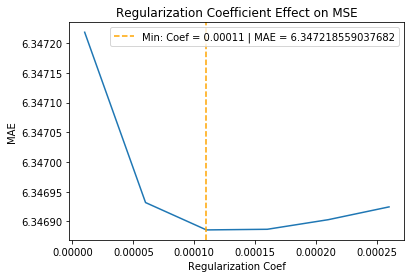

done


In [9]:
#Ridge Regression
reg_coef_list = np.arange(.00001, .0003, .00005) #np.concatenate( (np.arange(0.05, 1.0, 0.05),np.arange(1, 10.0, 1)), axis=None) 
mse_list = []

for coef in reg_coef_list:
    start = time.process_time()
    linreg = linear_model.Ridge(normalize = True, alpha=coef, max_iter=5000)
    linreg.fit(X=X_train, y=y_train)
    y_pred = linreg.predict(X_valid)
    mae = metrics.mean_absolute_error(y_valid, y_pred)
    mse_list.append(mae)
    end = time.process_time()
    print('Model using '+str(coef)+' as the regularization coefficient completed in '+str(round(end-start,3))+'sec')

plt.plot(reg_coef_list, mse_list)
plt.axvline(x=reg_coef_list[mse_list.index(min(mse_list))], color='orange', linestyle='--', 
            label='Min: Coef = {}'.format(reg_coef_list[mse_list.index(min(mse_list))])+' | MAE = {}'.format(max(mse_list)))
plt.title("Regularization Coefficient Effect on MSE")
plt.xlabel("Regularization Coef")
plt.ylabel("MAE")
plt.legend()
plt.show()
print("done")

Model using 2e-05 as the regularization coefficient completed in 6.942sec
Model using 3.0000000000000004e-05 as the regularization coefficient completed in 5.04sec
Model using 4.000000000000001e-05 as the regularization coefficient completed in 5.418sec
Model using 5.000000000000001e-05 as the regularization coefficient completed in 5.176sec
Model using 6.000000000000001e-05 as the regularization coefficient completed in 3.583sec
Model using 7.000000000000001e-05 as the regularization coefficient completed in 3.209sec


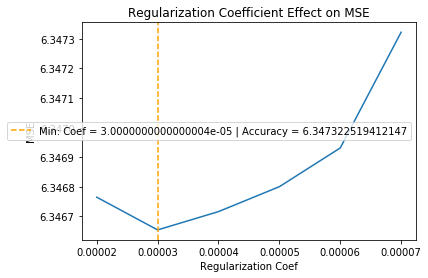

done


In [10]:
#Lasso Regression
reg_coef_list = np.arange(.00002, .00008, .00001) #np.concatenate( (np.arange(0.05, 1.0, 0.05),np.arange(1, 10.0, 1)), axis=None) 
mse_list = []

for coef in reg_coef_list:
    start = time.process_time()
    linreg = linear_model.Lasso(normalize = True, alpha=coef, max_iter=5000)
    linreg.fit(X=X_train, y=y_train)
    y_pred = linreg.predict(X_valid)
    mae = metrics.mean_absolute_error(y_valid, y_pred)
    mse_list.append(mae)
    end = time.process_time()
    print('Model using '+str(coef)+' as the regularization coefficient completed in '+str(round(end-start,3))+'sec')

plt.plot(reg_coef_list, mse_list)
plt.axvline(x=reg_coef_list[mse_list.index(min(mse_list))], color='orange', linestyle='--', 
            label='Min: Coef = {}'.format(reg_coef_list[mse_list.index(min(mse_list))])+' | Accuracy = {}'.format(max(mse_list)))
plt.title("Regularization Coefficient Effect on MSE")
plt.xlabel("Regularization Coef")
plt.ylabel("MSE")
plt.legend()
plt.show()
print("done")

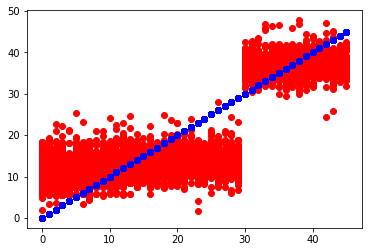

In [11]:
'''
Visualize at best lambda
'''

linreg = linear_model.Ridge(normalize = True, alpha=.00011, max_iter=5000)
linreg.fit(X=X_train, y=y_train)
y_pred = linreg.predict(X_valid)
plt.plot(y_valid, y_pred, 'ro')
plt.plot(y_valid, y_valid, 'bo' )
plt.show()
